# Hurricane Influence on US Stocks

### Overview 
Hurricanes are some of nature's most extreme weather events, with the potential to devastate coastlines, damage civilian infrasture and endager local residents. Given the severity of Hurrican's reaching landfall, many homeowners, local governments and emergency resposne agencies mobilize to help mitigate the damages caused by the storm, and prepare for extended periods of disruption to local conviennce. We are interested in examining the relationshp between these tropical storms and US equities, more specificlaly, we will examine Hurricans that have touched down on the US with companies that stand to benefiit from planning/prepping in anticipation of the storm.      

### Universe Selection: Stocks that Benefit during Hurricane Season
As expected, many industries play a vital role during hurricane season in providing neccessary supplies to weather the storm. We opt to examine two stocks that provide such supplies below [Link](https://bullishbears.com/hurricane-stocks/): 

**Home Improvement Companies**
- Home Depot (HD) and Lowe's (LMT) stand to benefit from consumers purchasing tools and construction materials.   

In [1]:
import os
import calendar
import statistics 
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from datetime import datetime
from scipy.stats import norm, t, chi2, skew, kurtosis 
from pandas.tseries.offsets import BMonthEnd, BDay
from pandas.tseries.holiday import USFederalHolidayCalendar

## Data Importation

In [2]:
def monthly_check(date_vector):
    """
    Returns the month-end points for the given date 
    """
    m_start = [0]
    m_end = []
    last_month = date_vector[0]

    for i, m_day in enumerate(date_vector):
        if (m_day != last_month):
            m_start.append(i)
            m_end.append(i-1)
        last_month = m_day
    
    return m_start[:-1], m_end

In [3]:
def log_rets(df:pd.DataFrame, freq:str='d'):
    """
    Construct the log-returns for a given equity security
    """
    assert freq in ['d', 'm'], "Frequency only accept daily (d) and monthly (m)"
    
    if freq == 'd':
        return df['Date'], np.log(df['Close'] / df['Open'])
    
    elif freq == 'm':
        df['Month'] = df['Date'].apply(lambda x: pd.to_datetime(x).month)
        
        m1, m2 = monthly_check(df.Month.values)
        y1 = df[np.isin(df['Date'], df['Date'].iloc[m1])]['Open'].values
        y2 = df[np.isin(df['Date'], df['Date'].iloc[m2])]['Close'].values
        
        return df[np.isin(df['Date'], df['Date'].iloc[m2])]['Date'], np.log(y2/y1)
    
    else:
        return 'Constructs only daily and monthly returns'

In [4]:
def clean_pdf(df:pd.DataFrame, date_vector) -> pd.DataFrame:
    """Wrapper script to clean the PDf for exportation"""
    
    df['Date'] = pd.to_datetime(date_vector).values

    df['Year'] = [pd.to_datetime(i).year for i in date_vector]
    df['Month'] = [pd.to_datetime(i).month for i in date_vector]
    df['ID'] =  df['Year'].astype(str) + "-" + df['Month'].astype(str)
    
    return df

In [5]:
timeseries = {}
month_rets = {}
daily_rets = {}
stocks = ['HD', 'LOW']

# iterate through the file directory to read data & transform for daily/monthly timeseries
for ticker in stocks:
    df = pd.read_csv(f'data/{ticker}.csv')
    
    timeseries[ticker] = df['Adj Close']
    m_datev, m_returns = log_rets(df, freq='m')
    d_datev, d_returns = log_rets(df, freq='d')
    
    month_rets[ticker] = m_returns
    daily_rets[ticker] = d_returns
    
# collect and export dataseries
monthly_portfolio_returns = pd.DataFrame(month_rets)
monthly_portfolio_returns = clean_pdf(monthly_portfolio_returns, m_datev)

daily_portfolio_returns = pd.DataFrame(daily_rets)
daily_portfolio_returns = clean_pdf(daily_portfolio_returns, d_datev)

portfolio_series = pd.DataFrame(timeseries)
portfolio_series = clean_pdf(portfolio_series, df['Date'].values)

In [6]:
# Dataset: https://www.aoml.noaa.gov/hrd/hurdat/All_U.S._Hurricanes.html
hurricane_us_landfall = pd.read_csv('data/hurricane_landfalls.csv')
hurricane_us_landfall = hurricane_us_landfall.dropna()

# month-map for numeric relationship 
month_map = dict((month, index) for index, month in enumerate(calendar.month_abbr) if month)

hurricane_us_landfall['Month'] = hurricane_us_landfall['Month'].apply(lambda x: month_map[x])
hurricane_us_landfall['ID'] =  hurricane_us_landfall['Year'].astype(str) + "-" + hurricane_us_landfall['Month'].astype(str)

In [7]:
hurricane_us_landfall.tail()

,Year,Month,States Affected and Category by States,Highest Saffir-Simpson U.S. Category,Central Pressure (mb),Max Wind (kt),Name,ID
43,2020,10,"LA,2",2.0,970.0,85.0,Delta,2020-10
44,2020,10,"LA,3; MS, 2; I-AL, 1",3.0,970.0,100.0,Zeta,2020-10
45,2021,8,"LA,4",4.0,931.0,130.0,Ida,2021-8
46,2021,9,"TX,N1",1.0,991.0,65.0,Nicholas,2021-9
47,2022,9,"FL, SW4; I-FL, SE1;FL, NE1; SC, 1",4.0,941.0,130.0,Ian,2022-9


## Preliminary Analysis

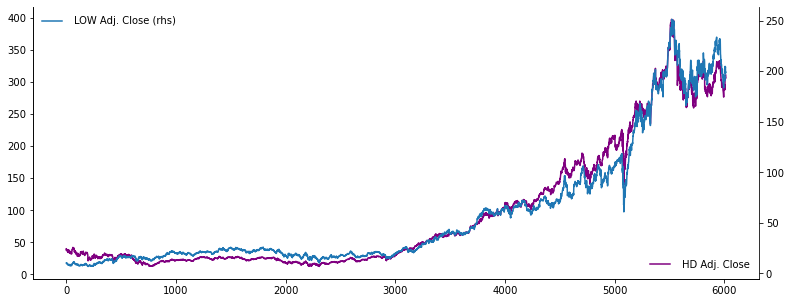

In [8]:
fig, ax = plt.subplots()
fig.set_figheight(5); fig.set_figwidth(13)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(portfolio_series['HD'], label='HD Adj. Close', color='purple')
ax.legend(prop={'size': 10}, loc='lower right', handletextpad=1.2, labelspacing=0.5, frameon=False)

ax2 = ax.twinx()
ax2.spines['top'].set_visible(False)

ax2.plot(portfolio_series['LOW'], label='LOW Adj. Close (rhs)')
ax2.legend(prop={'size': 10}, loc='upper left', handletextpad=1.2, labelspacing=0.5, frameon=False)

plt.show()

In [9]:
def confidence_bands(mu:float, std:float, n:int, alpha:float, param:str='mu'):
    """
    Confidence interval bands for a given alpha 
    """
    assert param in ['mu', 'var'], 'param: <str> accepting only mu or var key words'
    
    if param == 'mu':
        scale = abs(t.ppf(q=(1-alpha)/2, df=n-1))
        return mu-scale*std, mu+scale*std
    else:
        l = chi2.ppf(alpha, n-1)
        r = chi2.ppf(1-alpha, n-1)
        return (n-1)*(std**2/l), (n-1)*(std**2/r)

**Examining individual mean & variances for each stock, against Normality assumption**

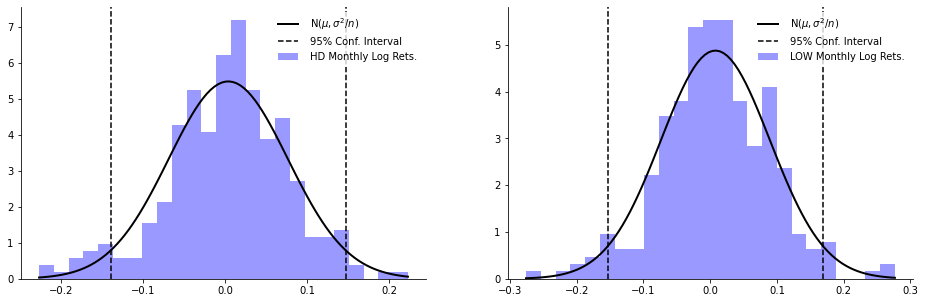

In [10]:
n, m = 1, 2 
fig, ax = plt.subplots(n, m)
fig.set_figheight(5); fig.set_figwidth(16)

alpha_lvl = 0.95   # confidence interval for the data bounds
params = {}
for i, ticker in enumerate(stocks): 

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    
    # fit a normal distribution against the data 
    mu, std = norm.fit(monthly_portfolio_returns[ticker].values)  

    # plot the PDF of the normal distribution with parameters 
    xmin, xmax = monthly_portfolio_returns[ticker].min(), monthly_portfolio_returns[ticker].max() 
    x = np.linspace(xmin, xmax, 100) 
    p = norm.pdf(x, mu, std) 
    
    # display the histogram for the given data
    ax[i].hist(monthly_portfolio_returns[ticker].values, bins=25, density=True, 
               alpha=0.4, color='b', label=f'{ticker} Monthly Log Rets.') 
    
    # display the PDF
    ax[i].plot(x, p, 'k', linewidth=2, label='N($\mu, \sigma^2/n$)') 
    
    # construct confidence interval on data center 
    degrees_freedom = monthly_portfolio_returns[ticker].values.size
    low, upp = confidence_bands(mu, std, degrees_freedom, alpha_lvl)
    
    ax[i].axvline(x=low, ls='--', color='k', label=f'{round(alpha_lvl*100)}% Conf. Interval')
    ax[i].axvline(x=upp, ls='--', color='k')
    
    ax[i].legend(prop={'size': 10}, handletextpad=1.2, labelspacing=0.5, frameon=True, 
                         facecolor='white', edgecolor='white')
    
    params[ticker] = {'mu': mu, 'std': std}
    
plt.show()

In [11]:
def simple_regression(X, Y, alpha=0.05, verbose=True):
    """
    Simple Regression
        X: indepenent variable, handling for time
        Y: dependent variable, endogenous variable
        verbose: output the summary of regression model
    """
    
    y_edog = pd.DataFrame(Y).reset_index(drop=True)
    
    try: 
        if X.shape[1] > 1:
            x_vars = {'const': np.ones((1, X.shape[0])).flatten()}
            x_vars.update(X.to_dict(orient='list'))
        else:
            x_vars = {
                'const': np.ones((1, X.shape[0])).flatten(), 
                'exog': X
            }
            
    except IndexError:
         x_vars = {
             'const': np.ones((1, X.shape[0])).flatten(), 
             'exog': X
         }
    
    x_exog = pd.DataFrame(x_vars)
    mod = sm.OLS(endog=y_edog, exog=x_exog.astype(float))
    res = mod.fit()
    
    if verbose:
        print(res.summary(alpha=alpha), '\n')
    
    return x_exog, y_edog, res

In [12]:
def regression_plots(X:np.ndarray, Y:np.ndarray, alpha=0.05, **kwargs):
    """
    Regression plots leveraging the simple regression model
        **kwargs = provide key-word arguments for labeling
    """
    
    fig, ax = plt.subplots(1, 2)
    fig.set_figheight(5); fig.set_figwidth(18)
    
    # examine month returns against hurricane stocks
    x, y, model = simple_regression(X, Y)
    
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    
    # linear regression line (OLS)
    b0, b1 = model.params.const, model.params.exog
    ax[0].plot(x.exog, b0 + x.exog*b1, lw=2, c='k', 
               label=f'$y={round(b0, 3)}+{round(b1, 3)}x$\n$R^2: {round(model.rsquared, 3)}$')
    
    # plot the residual for the regression 
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    
    ax[1].stem(model.resid.index, model.resid.values, linefmt=':', markerfmt='d')
    ax[1].set_title(f'Regression Residuals from Fit')
    
    # scatter plot for returns with graphical representation
    ax[0].scatter(x['exog'], y, color='tab:blue')
    ax[0].set_xlabel(f"{kwargs['x_name']}")
    ax[0].set_ylabel(f"{kwargs['y_name']}")
    
    ax[0].legend(prop={'size': 10}, handletextpad=1.2, labelspacing=0.5, frameon=False, 
                 facecolor='white', edgecolor='white')
    plt.show()



HD 1-month Log Returns Regresssed against Time

                            OLS Regression Results                            
Dep. Variable:                     HD   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.409
Date:                Sun, 03 Dec 2023   Prob (F-statistic):             0.0659
Time:                        12:13:28   Log-Likelihood:                 345.58
No. Observations:                 286   AIC:                            -687.2
Df Residuals:                     284   BIC:                            -679.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

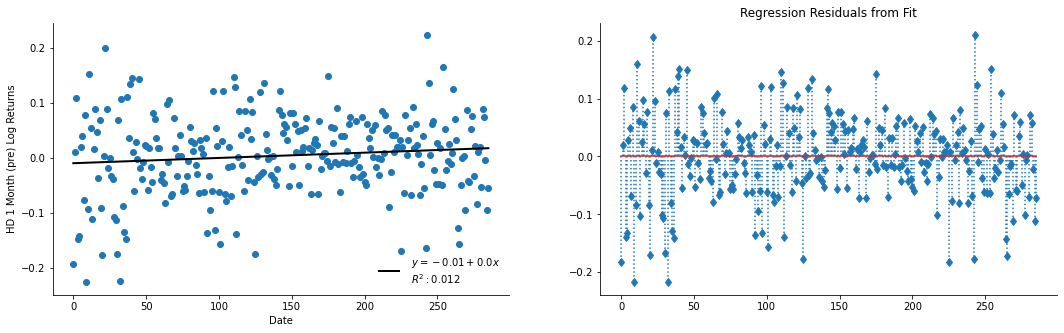



LOW 1-month Log Returns Regresssed against Time

                            OLS Regression Results                            
Dep. Variable:                    LOW   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1518
Date:                Sun, 03 Dec 2023   Prob (F-statistic):              0.697
Time:                        12:13:28   Log-Likelihood:                 310.30
No. Observations:                 286   AIC:                            -616.6
Df Residuals:                     284   BIC:                            -609.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

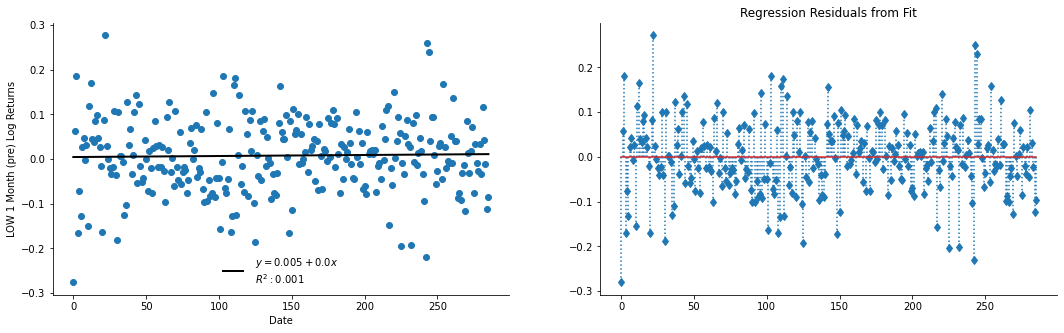

In [13]:
# plot the regression for each log-returns against time
alpha = 0.95
for i, ticker in enumerate(stocks):
    print('\n')
    print(f'\033[1m{ticker} 1-month Log Returns Regresssed against Time\033[0m\n')
    regression_plots(monthly_portfolio_returns.index, 
                     monthly_portfolio_returns[ticker], 
                     alpha=alpha,
                     y_name= f'{ticker} 1 Month (pre) Log Returns', 
                     x_name= f'Date')

In [14]:
def error_params(x:list, rets:pd.DataFrame, conf:str=0.95, param_type:str='mu'):
    """
    Construct error bar levels for each parameter (mean/variance) for the data 
    """
    mean = [0]*2
    lower_error = [0]*2
    upper_error = [0]*2
    
    n = rets.shape[0]
    
    for i, ticker in enumerate(x):
        mu, std = norm.fit(rets[ticker].values) 
        lower, upper = confidence_bands(mu, std, n, conf, param_type)
        
        if param_type == 'mu':
            mean[i] = mu
        else:
            mean[i] = std**2
        
        upper_error[i] = upper
        lower_error[i] = lower
        
    return x, mean, list(zip(lower_error, upper_error))

**Mean and Variance confidence intervals**

In [15]:
alpha_lvl = 0.95
for idx in ['mu', 'var']: 
    x_list, mid_list, err_list = error_params(x=stocks, rets=monthly_portfolio_returns, 
                                              conf=alpha_lvl, param_type=idx)
    print(f'{idx} parameter estimation, confidence at {round(alpha_lvl*100)}%')
    
    for j, ticker in enumerate(x_list):
        print(f'\t{ticker} => mean:{round(mid_list[j],4)} [{round(err_list[j][0], 4)}, {round(err_list[j][1], 4)}]')
    print()

mu parameter estimation, confidence at 95%
	HD => mean:0.0039 [-0.1392, 0.1471]
	LOW => mean:0.0079 [-0.1531, 0.1688]

var parameter estimation, confidence at 95%
	HD => mean:0.0053 [0.0046, 0.0061]
	LOW => mean:0.0067 [0.0059, 0.0077]



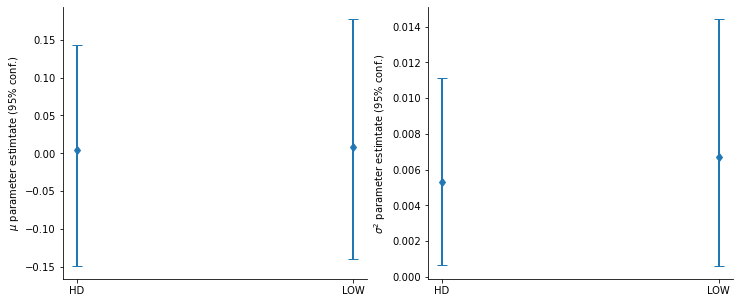

In [16]:
# Executable on local machine given older version of matplotlib

# # mean and variance plot
# alpha_lvl = 0.95

# fig, ax = plt.subplots(1, 2)
# fig.set_figheight(5); fig.set_figwidth(12)

# screen_map = {'mu': '$\mu$','var':'$\sigma^2$'}
# for i, idx in enumerate(['mu', 'var']):
    
#     ax[i].spines['right'].set_visible(False)
#     ax[i].spines['top'].set_visible(False)
    
#     x_list, mid_list, err_list = error_params(x=stocks, rets=monthly_portfolio_returns, 
#                                               conf=alpha_lvl, param_type=idx)
    
#     ax[i].errorbar(x=x_list, y=mid_list, xerr=None, yerr=err_list, 
#                    elinewidth=2, capsize=5, ls='none', marker='d')
#     ax[i].set_ylabel(f'{screen_map[idx]} parameter estimtate ({round(alpha_lvl*100)}% conf.)')
    
# plt.show()

**Quick assesment for the equality of the two population means: Not enough evidience to reject the Null (i.e. the stock's mean log return are equal)**

In [17]:
num = params['HD']['mu'] - params['LOW']['mu'] 
dem = np.sqrt( (1/monthly_portfolio_returns.shape[0]) * (params['HD']['std']**2 + params['LOW']['std']**2) )
Z = abs(round(num/dem, 4))

for alpha in [0.90, 0.95, 0.99]:
    critical_points = round(norm.ppf(alpha+(1-alpha)/2), 4)
    
    if Z > critical_points:
        print(f'[Reject Null] Current Z-score |{Z}| > {critical_points} for an alpha of {round(alpha*100)}%')
    else:
        print(f'[Do Not Reject] Current Z-score |{Z}| < {critical_points} for an alpha of {round(alpha*100)}%')

[Do Not Reject] Current Z-score |0.6049| < 1.6449 for an alpha of 90%
[Do Not Reject] Current Z-score |0.6049| < 1.96 for an alpha of 95%
[Do Not Reject] Current Z-score |0.6049| < 2.5758 for an alpha of 99%


**Regression: Home Depot Returns relative to Lowe's Return**

                            OLS Regression Results                            
Dep. Variable:                     HD   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     373.5
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           1.07e-53
Time:                        12:13:28   Log-Likelihood:                 463.91
No. Observations:                 286   AIC:                            -923.8
Df Residuals:                     284   BIC:                            -916.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.003     -0.463      0.6

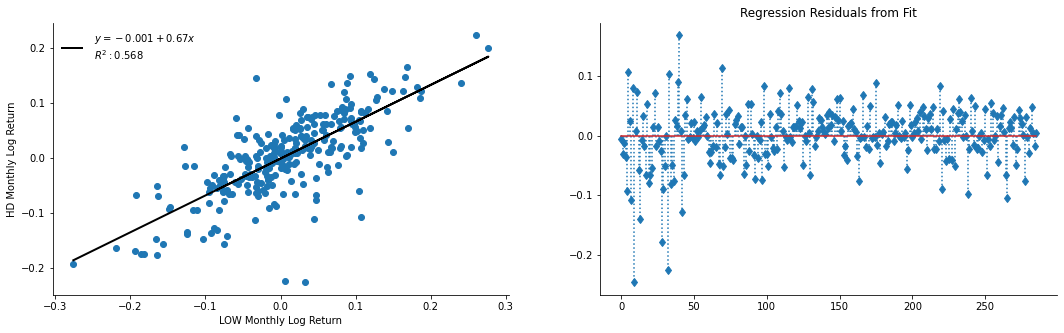

In [18]:
regression_plots(monthly_portfolio_returns['LOW'], 
                 monthly_portfolio_returns['HD'], 
                 alpha=0.95,
                 y_name= 'HD Monthly Log Return', 
                 x_name= 'LOW Monthly Log Return')

In [19]:
y_edog = monthly_portfolio_returns['HD']
x_exog = pd.DataFrame({
    'const': np.ones((1, monthly_portfolio_returns.shape[0])).flatten(), 
    'slope': monthly_portfolio_returns['LOW']
})

mod = sm.OLS(endog=y_edog, exog=x_exog)
res = mod.fit()

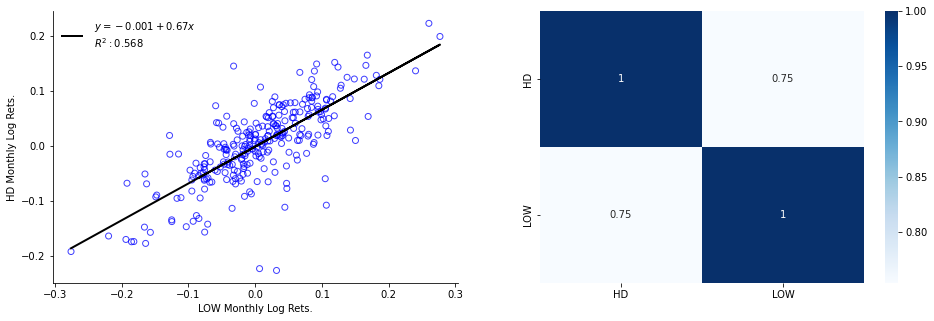

In [20]:
fig, ax = plt.subplots(1, 2)
fig.set_figheight(5); fig.set_figwidth(16)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

# linear regression line (OLS)
b0, b1 = res.params.const, res.params.slope
ax[0].plot(x_exog.slope, b0 + x_exog.slope*b1, lw=2, c='k', 
        label=f'$y={round(b0, 3)}+{round(b1, 3)}x$\n$R^2: {round(res.rsquared, 3)}$')

# scatter plot for returns with graphical representation
ax[0].scatter(x_exog['slope'], y_edog, facecolors='none', edgecolor='b', alpha=0.75)
ax[0].set_xlabel('LOW Monthly Log Rets.')
ax[0].set_ylabel('HD Monthly Log Rets.')

ax[0].legend(prop={'size': 10}, handletextpad=1.2, labelspacing=0.5, frameon=False, facecolor='white', edgecolor='black')

# correlation heatmap
sns.heatmap(monthly_portfolio_returns[stocks].corr(), 
            annot=True, 
            cmap='Blues', 
            ax=ax[1])

plt.show()

**Introducing the Hurricane dataset into the stock performance, highlighted with red bars for month of occurence**

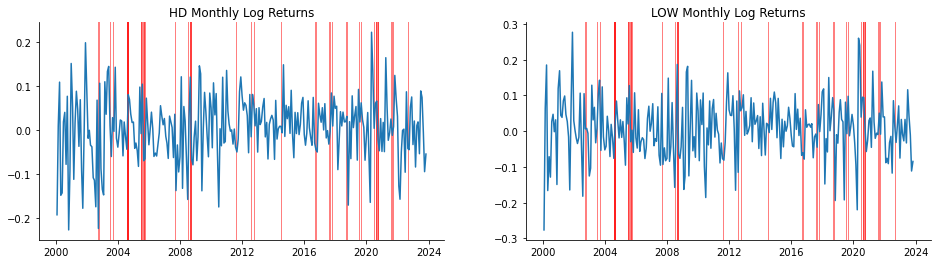

In [21]:
n, m = 1, 2
fig, ax = plt.subplots(n, m)
fig.set_figheight(4); fig.set_figwidth(16)

points = [(i,j) for i in range(n) for j in range(m)]

for i, ticker in enumerate(stocks): 
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    ax[i].plot(monthly_portfolio_returns['Date'], monthly_portfolio_returns[ticker])

    # iterate through the range of hurricans
    for j in hurricane_us_landfall.index:
        y, m = hurricane_us_landfall.loc[j].Year, hurricane_us_landfall.loc[j].Month
        
        filter_df = portfolio_series[(portfolio_series.Year == y) & (portfolio_series.Month == m)]
        ax[i].axvspan(filter_df.Date.iloc[0], filter_df.Date.iloc[-1], facecolor='r', alpha=0.5)
    
    ax[i].set_title(f'{ticker} Monthly Log Returns')
    
plt.show()

## Linear Regression

In [22]:
def month_shifter(df:pd.DataFrame, shift:int=1):
    """
    Function to modify the month and year columns in accordance with time lag 
    shift:int +1 (month forward), -1 (month backward)
    """
    
    data = df.copy()
    
    # indicates a forward shift i.e. month-ahead is brought back 1-month
    data['Month'] = data['Month']+shift
    year_shift = np.ceil(abs(shift/12))
    
    if shift < 0:
        # adjust year handle according to month shift e.g. January less one pushes year back
        data['Year'] = data[['Year', 'Month']].apply(lambda x: x[0]-year_shift if x[1] <= 0 else x[0], axis=1).astype(int)
        data['Month'] = data['Month'].apply(lambda x: x%12 if x < 0 else (12 if x == 0 else x))
    else:
        data['Year'] = data[['Year', 'Month']].apply(lambda x: x[0]+year_shift if x[1] > 12 else x[0], axis=1).astype(int)
        data['Month'] = data['Month'].apply(lambda x: 12 if (x%12 == 0) else (x%12 if x > 12 else x))
    
    return data

In [23]:
# compute lagged effects i.e. one month before and after hurricane reaches landfall
month_bm = month_shifter(hurricane_us_landfall, shift=-1)
month_bm['ID'] =  month_bm['Year'].astype(str) + "-" + month_bm['Month'].astype(str)

month_fm = month_shifter(hurricane_us_landfall, shift=1)
month_fm['ID'] =  month_fm['Year'].astype(str) + "-" + month_fm['Month'].astype(str)

In [24]:
# determine the binary for the pre/post hurricane effects (note given hurricane proximity we may have overlap)
monthly_portfolio_returns['Pre-Hurricane Month'] = monthly_portfolio_returns['ID'].apply(lambda x: 1 if x in month_bm.ID.values else 0)
monthly_portfolio_returns['Post-Hurricane Month'] = monthly_portfolio_returns['ID'].apply(lambda x: 1 if x in month_fm.ID.values else 0)
monthly_portfolio_returns['Time'] = monthly_portfolio_returns.index + 1

In [25]:
monthly_portfolio_returns.head()

,HD,LOW,Date,Year,Month,ID,Pre-Hurricane Month,Post-Hurricane Month,Time
0,-0.192206,-0.276060,2000-01-31,2000,1,2000-1,0,0,1
1,0.009831,0.063406,2000-02-29,2000,2,2000-2,0,0,2
2,0.109460,0.185324,2000-03-31,2000,3,2000-3,0,0,3
3,-0.147810,-0.165985,2000-04-28,2000,4,2000-4,0,0,4
4,-0.142420,-0.071228,2000-05-31,2000,5,2000-5,0,0,5


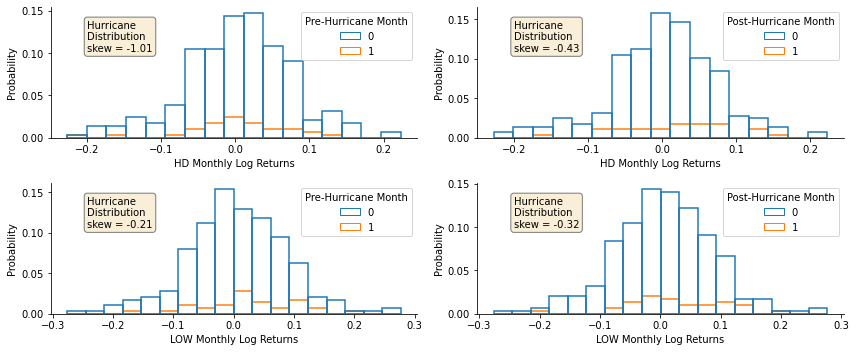

In [26]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(5); fig.set_figwidth(12)

i = 0
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

for ticker in stocks:
    j = 0
    
    for session in ['Pre-Hurricane Month', 'Post-Hurricane Month']:
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['top'].set_visible(False)
        sns.histplot(data=monthly_portfolio_returns, x=ticker, fill=False, 
                     stat='probability', hue=session, ax=ax[i, j])
        ax[i, j].set_xlabel(f'{ticker} Monthly Log Returns')
        
        # place a text box in upper left in axes coords
        skew_val = skew(monthly_portfolio_returns[monthly_portfolio_returns[session] == 1][ticker])
        textstr = f'Hurricane\nDistribution\nskew = {round(skew_val, 2)}'
        ax[i, j].text(0.1, 0.9, textstr, transform=ax[i, j].transAxes, 
                      fontsize=10, verticalalignment='top', bbox=props)
        
        j += 1
    i += 1

plt.tight_layout()
plt.show()

In [27]:
# chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.ncei.noaa.gov/access/billions/dcmi.pdf
point_selection1 = month_shifter(month_fm[month_fm['Name'] == 'Katrina'], shift=-1) 
point_selection1['ID'] = point_selection1['Year'].astype(str) + "-" + point_selection1['Month'].astype(str)

point_selection2 = month_shifter(month_fm[month_fm['Name'] == 'Katrina'], shift=1) 
point_selection2['ID'] = point_selection2['Year'].astype(str) + "-" + point_selection2['Month'].astype(str)

In [28]:
point_selection1

,Year,Month,States Affected and Category by States,Highest Saffir-Simpson U.S. Category,Central Pressure (mb),Max Wind (kt),Name,ID
13,2005,8,"FL, SE1, SW1; LA, 3; MS, 3; AL, 1",3.0,920.0,110.0,Katrina,2005-8


**Regresion: Pre-Hurricane Event**



HD 1-month (pre) Log Returns Regresssed against US Hurricane Landfalls

                            OLS Regression Results                            
Dep. Variable:                     HD   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.720
Date:                Sun, 03 Dec 2023   Prob (F-statistic):              0.181
Time:                        12:13:30   Log-Likelihood:                 345.60
No. Observations:                 286   AIC:                            -685.2
Df Residuals:                     283   BIC:                            -674.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t| [0.025000000000000022      0.975]
--------------------------------------

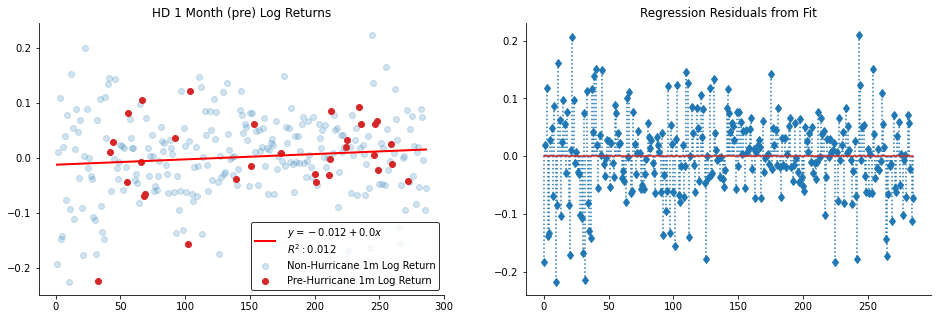



LOW 1-month (pre) Log Returns Regresssed against US Hurricane Landfalls

                            OLS Regression Results                            
Dep. Variable:                    LOW   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7394
Date:                Sun, 03 Dec 2023   Prob (F-statistic):              0.478
Time:                        12:13:30   Log-Likelihood:                 310.97
No. Observations:                 286   AIC:                            -615.9
Df Residuals:                     283   BIC:                            -605.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t| [0.025000000000000022      0.975]
-------------------------------------

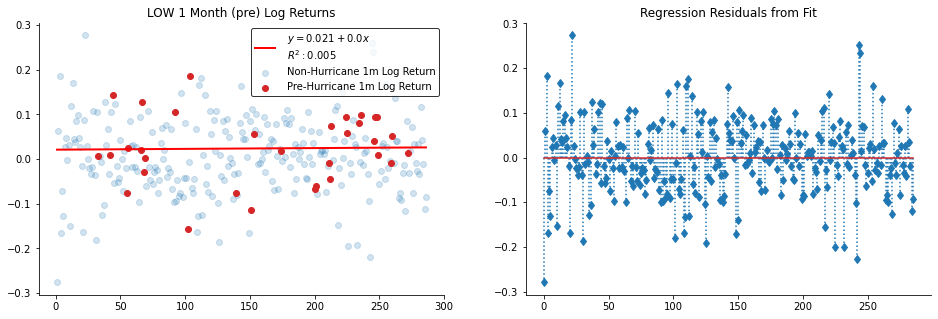

In [29]:
alpha = 0.95

for ticker in stocks:
    print('\n')
    print(f'\033[1m{ticker} 1-month (pre) Log Returns Regresssed against US Hurricane Landfalls\033[0m\n')
    
    # examine month returns against hurricane stocks
    x, y, model = simple_regression(X=monthly_portfolio_returns[['Time', 'Pre-Hurricane Month']], 
                                    Y=monthly_portfolio_returns[ticker], alpha=1-alpha)

    fig, ax = plt.subplots(1, 2)
    fig.set_figheight(5); fig.set_figwidth(16)

    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    
    # linear regression line (OLS)
    b0, b1, b2 = model.params.loc['const'], model.params.loc['Time'], model.params.loc['Pre-Hurricane Month']
    
    h_zone = x[x['Pre-Hurricane Month'] == 1].index
    n_zone = x[x['Pre-Hurricane Month'] == 0].index
    ax[0].plot(x['Time'], b0 + x['Time']*b1 + b2, 
               lw=2, c='r', label=f'$y={round(b0+b2, 3)}+{round(b1, 3)}x$\n$R^2: {round(model.rsquared, 3)}$')
    
    # plot the residual for the hurricane dummy regression 
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    
    ax[1].stem(model.resid.index, model.resid.values, linefmt=':', markerfmt='d')
    ax[1].set_title(f'Regression Residuals from Fit')
    
    # scatter plot for returns with graphical representation
    ax[0].scatter(x['Time'].loc[n_zone], y.loc[n_zone], color='tab:blue', alpha=0.2, label='Non-Hurricane 1m Log Return')
    ax[0].scatter(x['Time'].loc[h_zone], y.loc[h_zone], color='tab:red', label='Pre-Hurricane 1m Log Return')
    ax[0].set_title(f'{ticker} 1 Month (pre) Log Returns')

    ax[0].legend(prop={'size': 10}, handletextpad=1.2, labelspacing=0.5, frameon=True, 
                 facecolor='white', edgecolor='k')
    
    plt.show()

**Regresion: Post-Hurricane Event**



HD 1-month (post) Log Returns Regresssed against US Hurricane Landfalls

                            OLS Regression Results                            
Dep. Variable:                     HD   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.632
Date:                Sun, 03 Dec 2023   Prob (F-statistic):             0.0737
Time:                        12:13:30   Log-Likelihood:                 346.51
No. Observations:                 286   AIC:                            -687.0
Df Residuals:                     283   BIC:                            -676.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t| [0.025000000000000022      0.975]
------------------------------------

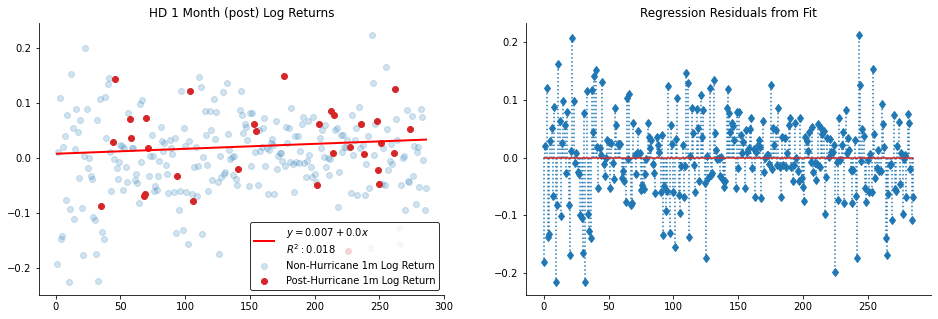



LOW 1-month (post) Log Returns Regresssed against US Hurricane Landfalls

                            OLS Regression Results                            
Dep. Variable:                    LOW   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.007
Date:                Sun, 03 Dec 2023   Prob (F-statistic):              0.367
Time:                        12:13:31   Log-Likelihood:                 311.23
No. Observations:                 286   AIC:                            -616.5
Df Residuals:                     283   BIC:                            -605.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t| [0.025000000000000022      0.975]
-----------------------------------

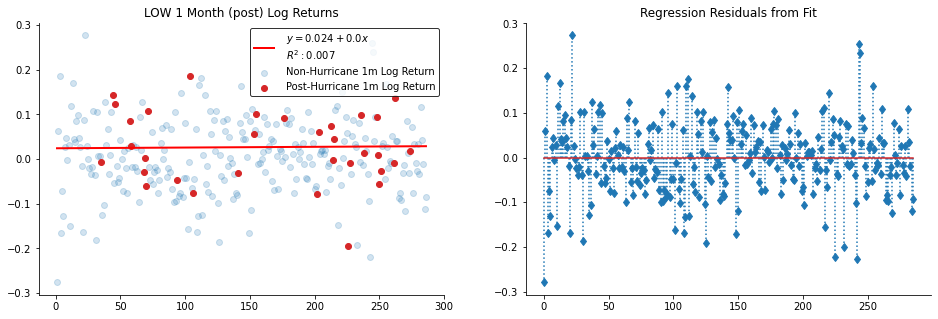

In [30]:
alpha = 0.95

for ticker in stocks:
    print('\n')
    print(f'\033[1m{ticker} 1-month (post) Log Returns Regresssed against US Hurricane Landfalls\033[0m\n')
    
    # examine month returns against hurricane stocks
    x, y, model = simple_regression(X=monthly_portfolio_returns[['Time', 'Post-Hurricane Month']], 
                                    Y=monthly_portfolio_returns[ticker], alpha=1-alpha)

    fig, ax = plt.subplots(1, 2)
    fig.set_figheight(5); fig.set_figwidth(16)

    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    
    # linear regression line (OLS)
    b0, b1, b2 = model.params.loc['const'], model.params.loc['Time'], model.params.loc['Post-Hurricane Month']
    
    h_zone = x[x['Post-Hurricane Month'] == 1].index
    n_zone = x[x['Post-Hurricane Month'] == 0].index
    ax[0].plot(x['Time'], b0 + x['Time']*b1 + b2, 
               lw=2, c='r', label=f'$y={round(b0+b2, 3)}+{round(b1, 3)}x$\n$R^2: {round(model.rsquared, 3)}$')
    
    # plot the residual for the hurricane dummy regression 
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    
    ax[1].stem(model.resid.index, model.resid.values, linefmt=':', markerfmt='d')
    ax[1].set_title(f'Regression Residuals from Fit')
    
    # scatter plot for returns with graphical representation
    ax[0].scatter(x['Time'].loc[n_zone], y.loc[n_zone], color='tab:blue', alpha=0.2, label='Non-Hurricane 1m Log Return')
    ax[0].scatter(x['Time'].loc[h_zone], y.loc[h_zone], color='tab:red', label='Post-Hurricane 1m Log Return')
    ax[0].set_title(f'{ticker} 1 Month (post) Log Returns')

    ax[0].legend(prop={'size': 10}, handletextpad=1.2, labelspacing=0.5, frameon=True, 
                 facecolor='white', edgecolor='k')
    
    plt.show()

**Display graph before and after the event of occurenc**

In [31]:
# determine the binary for the pre/post hurricane effects (note given hurricane proximity we may have overlap)
daily_portfolio_returns['Pre-Hurricane Month'] = daily_portfolio_returns['ID'].apply(lambda x: 1 if x in month_bm.ID.values else 0)
daily_portfolio_returns['Post-Hurricane Month'] = daily_portfolio_returns['ID'].apply(lambda x: 1 if x in month_fm.ID.values else 0)
daily_portfolio_returns['Time'] = daily_portfolio_returns.index + 1

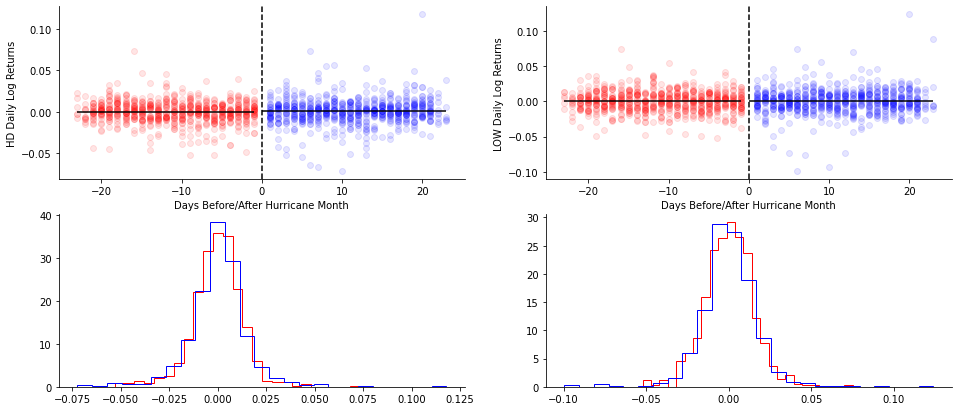

In [65]:
a1 = daily_portfolio_returns[daily_portfolio_returns['Pre-Hurricane Month'] == 1]
a2 = daily_portfolio_returns[daily_portfolio_returns['Post-Hurricane Month'] == 1]

fig, ax = plt.subplots(2, 2)
fig.set_figheight(7); fig.set_figwidth(16)
    
for axi, ticker in enumerate(stocks):
    ax[0, axi].spines['right'].set_visible(False)
    ax[0, axi].spines['top'].set_visible(False)
    ax[1, axi].spines['right'].set_visible(False)
    ax[1, axi].spines['top'].set_visible(False)
    
    # Pre-Hurricane Returns
    base = [0]*a1['ID'].unique().size
    for idx, i in enumerate(a1['ID'].unique()):
        days = a1[a1['ID'] == i].shape[0]
        ax[0, axi].scatter(np.arange(-days, 0), a1[a1['ID'] == i][ticker].values, alpha=0.1, c='r')
        base[idx] = a1[a1['ID'] == i][ticker].values

    ax[0, axi].hlines(np.array([i.mean() for i in base]).mean(), -23, -1, color='k')
    
    # Distribution for the returns pre and post
    ax[1, axi].hist(a1[ticker].values, bins=25, histtype='step', density=True, color='r')
    
    # Post-Hurricane Returns
    base = [0]*a2['ID'].unique().size
    for idx, i in enumerate(a2['ID'].unique()):
        days = a2[a2['ID'] == i].shape[0]
        ax[0, axi].scatter(np.arange(1, days+1), a2[a2['ID'] == i][ticker].values, alpha=0.1, c='b')
        base[idx] = a2[a2['ID'] == i][ticker].values

    ax[0, axi].hlines(np.array([i.mean() for i in base]).mean(), 0, 23, color='k')
    
    # Distribution for the returns pre and post
    ax[1, axi].hist(a2[ticker].values, bins=25, density=True, histtype='step', color='b')
    
    # High level shift
    ax[0, axi].set_ylabel(f'{ticker} Daily Log Returns')
    ax[0, axi].set_xlabel(f'Days Before/After Hurricane Month')
    ax[0, axi].axvline(0, c='k', ls='--')
    
plt.show()

In [74]:
# fit a normal distribution against the data 
for ticker in stocks:
    print(f'{ticker} Pre-Hurricane vs Post-Hurricane (mean equality)')
    
    mu1, std1 = norm.fit(a1[ticker].values)  
    mu2, std2 = norm.fit(a2[ticker].values)  
    
    num = mu1 - mu2 
    dem = np.sqrt( (1/a1['HD'].size) * (std1**2 + std2**2) )
    Z = abs(round(num/dem, 4))

    for alpha in [0.90, 0.95, 0.99]:
        critical_points = round(norm.ppf(alpha+(1-alpha)/2), 4)

        if Z > critical_points:
            print(f'\t[Reject Null] Current Z-score |{Z}| > {critical_points} for an alpha of {round(alpha*100)}%')
        else:
            print(f'\t[Do Not Reject] Current Z-score |{Z}| < {critical_points} for an alpha of {round(alpha*100)}%')
    print()

HD Pre-Hurricane vs Post-Hurricane (mean equality)
	[Do Not Reject] Current Z-score |0.986| < 1.6449 for an alpha of 90%
	[Do Not Reject] Current Z-score |0.986| < 1.96 for an alpha of 95%
	[Do Not Reject] Current Z-score |0.986| < 2.5758 for an alpha of 99%

LOW Pre-Hurricane vs Post-Hurricane (mean equality)
	[Do Not Reject] Current Z-score |0.0902| < 1.6449 for an alpha of 90%
	[Do Not Reject] Current Z-score |0.0902| < 1.96 for an alpha of 95%
	[Do Not Reject] Current Z-score |0.0902| < 2.5758 for an alpha of 99%



**Deconstructing the $t$ significance fallacy i.e. $time$ is not indicative for returns**

                            OLS Regression Results                            
Dep. Variable:                     HD   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1108
Date:                Sun, 03 Dec 2023   Prob (F-statistic):              0.739
Time:                        12:34:04   Log-Likelihood:                 343.93
No. Observations:                 286   AIC:                            -683.9
Df Residuals:                     284   BIC:                            -676.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.009      0.747      0.4

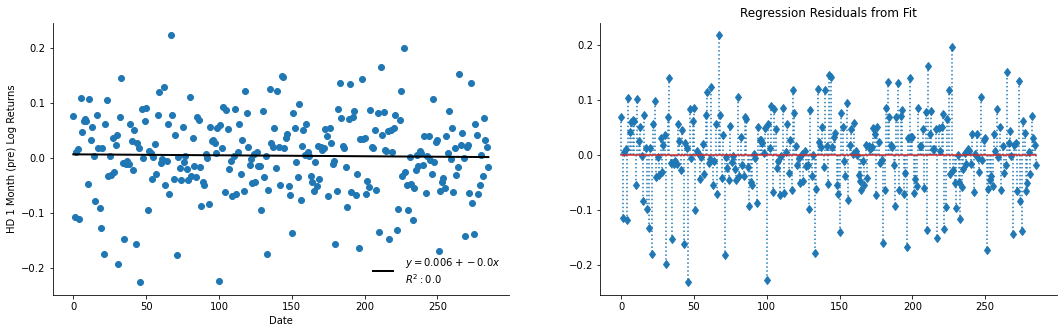

In [37]:
# randomize the order of points to disrupt time component
A = monthly_portfolio_returns.sample(frac = 1).reset_index(drop=True)
# A = monthly_portfolio_returns.sort_values('HD').reset_index(drop=True)

regression_plots(A.index, A['HD'], alpha=alpha,
                 y_name= f'HD 1 Month (pre) Log Returns', 
                 x_name= f'Date')

In [49]:
# examine month returns against hurricane stocks
x, y, model = simple_regression(X=monthly_portfolio_returns[['Time', 'Post-Hurricane Month']], 
                                Y=monthly_portfolio_returns['HD'], 
                                alpha=1-alpha, 
                                verbose=False)


h_zone = x[x['Post-Hurricane Month'] == 1].index
n_zone = x[x['Post-Hurricane Month'] == 0].index

print(f'Non-Hurricane STD: {round(np.std(y.loc[n_zone])[0], 5)}')
print(f'Post-Hurricane STD: {round(np.std(y.loc[h_zone])[0], 5)}')

Non-Hurricane STD: 0.07253
Post-Hurricane STD: 0.07156
